In [1]:
#############
###paths#####
#############
import sys
import os

pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
sys.path.append(modellingpath + '/lib')
#############
import pickle as pkl
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:

def plotData(inducer, rfpExp_list, gfpExp_list, semRed, semGreen,pad=0.01, inducerName='OC14'):
    fig,ax = plt.subplots()

    ax.plot(inducer,rfpExp_list,label='RFP', c='red')
    ax.scatter(inducer,rfpExp_list, c='red')
    ax.errorbar(inducer,rfpExp_list,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$')
    ax.set_xscale('log')


    ax2=ax.twinx()
    ax2.plot(inducer,gfpExp_list,label='GFP', c='green')
    ax2.scatter(inducer,gfpExp_list, c='green')
    ax2.errorbar(inducer,gfpExp_list,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$')
    ax.set_xscale('log')
    ax.set_xlabel(f'{inducerName} concentration (µM)')

    plt.show()

def plotFitvsData(inducer,inducer_continuous, gfpExp_list, rfpExp_list, semGreen, semRed,doseResponseGreen,doseResponseRed,pad=0.01):
    fig,ax = plt.subplots()

    ax.plot(inducer_continuous,doseResponseRed,label='RFP', c='red')
    ax.scatter(inducer,rfpExp_list, c='red')
    ax.errorbar(inducer,rfpExp_list,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$')
    ax.set_xscale('log')


    ax2=ax.twinx()
    ax2.plot(inducer_continuous,doseResponseGreen,label='GFP', c='green')
    ax2.scatter(inducer,gfpExp_list, c='green')
    ax2.errorbar(inducer,gfpExp_list,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$')
    ax.set_xscale('log')


    plt.show()


## Combined subcircuits

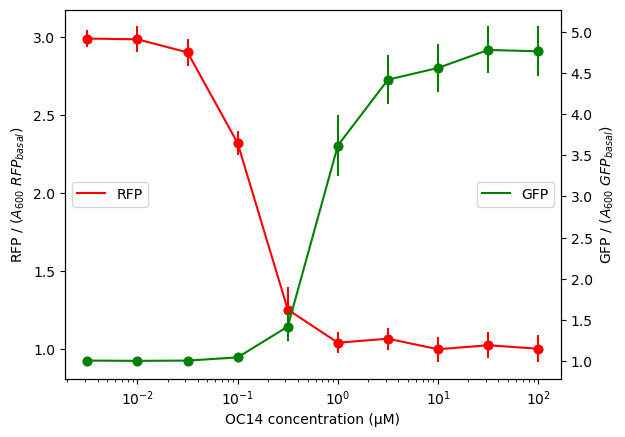

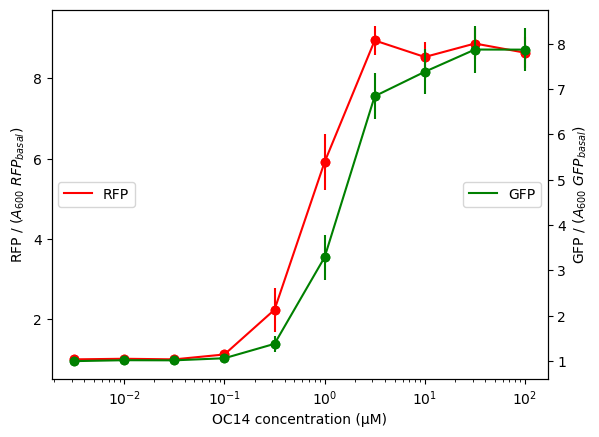

8.946564885496183


In [3]:
doseResponseExp1 = pkl.load(open('input/liquid_culture/curatedData/Jure_subcircuit1_circuit14_doseResponseOC14_0.5ATC.pkl','rb'))
OC14_list1= np.array(doseResponseExp1['OC14']); gfpExp_list1 = list(doseResponseExp1['mean_gfp']); rfpExp_list1 = list(doseResponseExp1['mean_rfp'])
semGreen1 = doseResponseExp1['std_gfp']; semRed1 = doseResponseExp1['std_rfp']
plotData(OC14_list1, rfpExp_list1, gfpExp_list1, semRed1, semGreen1)



doseResponseExp3 = pkl.load(open('input/liquid_culture/curatedData/Jure_subcircuit3_circuit14_doseResponseOC14_0.5ATC.pkl','rb'))
OC14_list3= np.array(doseResponseExp3['OC14']); gfpExp_list3 = list(doseResponseExp3['mean_gfp']); rfpExp_list3 = list(doseResponseExp3['mean_rfp'])
semGreen3 = doseResponseExp3['std_gfp']; semRed3 = doseResponseExp3['std_rfp']
plotData(OC14_list3, rfpExp_list3, gfpExp_list3, semRed3, semGreen3)
print(np.amax([rfpExp_list3, rfpExp_list1]))


In [4]:


nvd = 2
nfe = 10
nda=2
nce=3

Ve = np.amax([rfpExp_list3, rfpExp_list1]) - 1
# Ve =5.88


def gfp1_steadystate(OC14, Vf,Kvd): 
    muv = 0.0225 ; kv =  0.0183 ;
    F1 = 1 + Vf*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd ))
    return F1

# def rfp1_steadystate(OC14, Vf,Kvd,Ve,Kfe): 
#     muv = 0.0225 ; kv =  0.0183 ;
#     E1 = 1 + Ve*(1/(1+((1 + Vf*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd )))/(Kfe+1e-8))**nfe))

#     return E1

def rfp1_steadystate(OC14, Vf,Kvd,Kfe): 
    muv = 0.0225 ; kv =  0.0183 ;
    E1 = 1 + Ve*(1/(1+((1 + Vf*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd )))/(Kfe+1e-8))**nfe))

    return E1

def gfp3_steadystate(OC14,  Vd,Kvd): 
    muv = 0.0225 ; kv =  0.0183 ;
    D3 = 1 + Vd*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd ))
    return D3

def bfp3_steadystate(D,Vc,Kda):
    C3 = 1 + Vc*(1/(1+((D/(Kda+1e-8))**nda)))
    return C3

# def rfp3_steadystate(D,Vc, Kda,  Ve,Kce): 

#     E3 = 1 + Ve*(1/(1+((bfp3_steadystate(D, Vc, Kda)/(Kce+1e-8))**nce)))
#     return E3

def rfp3_steadystate(D,Vc, Kda,Kce): 

    E3 = 1 + Ve*(1/(1+((bfp3_steadystate(D, Vc, Kda)/(Kce+1e-8))**nce)))
    return E3

OC14_continuous = np.logspace(-3,2, 100)


# def steadystate(OC14,Vc,Vd,Ve,Vf, Kvd,Kda, Kfe, Kce):
def steadystate(OC14,Vc,Vd,Vf, Kvd,Kda, Kfe, Kce):
  
  if len(OC14) == 22:
      gaps = [5,5,6,6]
  else:
        gaps = [int(len(OC14)/4)]*4
  F1 = gfp1_steadystate(OC14[:np.sum(gaps[:1])],  Vf,Kvd)
#   E1 = rfp1_steadystate(OC14[np.sum(gaps[:1]):np.sum(gaps[:2])],Vf,Kvd,Ve,Kfe)
  E1 = rfp1_steadystate(OC14[np.sum(gaps[:1]):np.sum(gaps[:2])],Vf,Kvd,Kfe)
  D3 = gfp3_steadystate(OC14[np.sum(gaps[:2]):np.sum(gaps[:3])], Vd,Kvd)
#   E3 = rfp3_steadystate(OC14[np.sum(gaps[:3]):np.sum(gaps[:4])], Vc, Kda,  Ve,Kce)
  E3 = rfp3_steadystate(OC14[np.sum(gaps[:3]):np.sum(gaps[:4])], Vc, Kda,Kce)
  FE = np.hstack([F1,E1, D3, E3])
  return FE


fluorescenceData = np.hstack([gfpExp_list1,rfpExp_list1, gfpExp_list3,rfpExp_list3])
OC14data_new = np.hstack([OC14_list1,OC14_list1, OC14_list3,OC14_list3])
OC14data_continuous= np.hstack([OC14_continuous,OC14_continuous, OC14_continuous,OC14_continuous])
semStacked= np.hstack([semGreen1,semRed1, semGreen3,semRed3])

popt, pcov = curve_fit(f=steadystate, xdata=OC14data_new, ydata=fluorescenceData ,sigma =semStacked)
# popt, pcov = curve_fit(f=steadystate, xdata=OC14data_new, ydata=fluorescenceData )

# paramNames = ['Vc','Vd','Ve','Vf', 'Kvd','Kda', 'Kfe', 'Kce']
paramNames = ['Vc','Vd','Vf', 'Kvd','Kda', 'Kfe', 'Kce']
pfitDict = {}
for param in popt:
    pfitDict[paramNames[popt.tolist().index(param)]] = param
pfitDict

{'Vc': 19.9552167334331,
 'Vd': 6.471382103657136,
 'Vf': 3.822697555075737,
 'Kvd': 0.7888206020550087,
 'Kda': 0.32780622726881464,
 'Kfe': 0.8941487200868288,
 'Kce': 3.58774099860374}

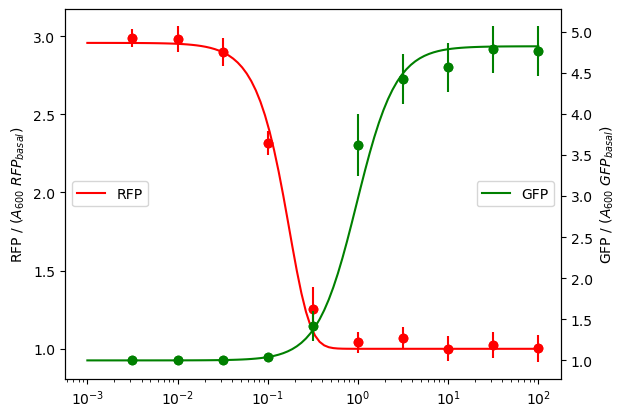

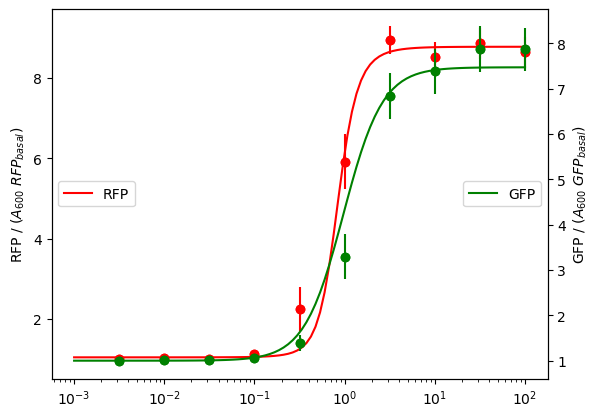

In [5]:
fluorescenceFit = steadystate(OC14data_new, *popt)
fluorescenceFit_continuous = steadystate(OC14data_continuous, *popt)
gfpFit1 = fluorescenceFit[:10]; rfpFit1 = fluorescenceFit[10:20]; gfpFit3 = fluorescenceFit[20:30]; rfpFit3 = fluorescenceFit[30:40]
gfpFit1_continuous = fluorescenceFit_continuous[:100]; rfpFit1_continuous = fluorescenceFit_continuous[100:200]; gfpFit3_continuous = fluorescenceFit_continuous[200:300]; rfpFit3_continuous = fluorescenceFit_continuous[300:400]

plotFitvsData(OC14_list1,OC14_continuous, gfpExp_list1, rfpExp_list1, semGreen1, semRed1, gfpFit1_continuous,rfpFit1_continuous)

plotFitvsData(OC14_list3,OC14_continuous, gfpExp_list3, rfpExp_list3, semGreen3, semRed3, gfpFit3_continuous,rfpFit3_continuous)
gfpFit1_continuous_copy,rfpFit1_continuous_copy, gfpFit3_continuous_copy,rfpFit3_continuous_copy = gfpFit1_continuous,rfpFit1_continuous, gfpFit3_continuous,rfpFit3_continuous 



In [6]:


sampled_parameters = np.random.multivariate_normal(popt,pcov*100, size=1000, check_valid='warn')#


In [16]:
def steadystateloss(OC14,Vc,Vd,Ve,Vf, Kvd,Kda, Kfe, Kce):

  F1 = gfp1_steadystate(OC14, Vf,Kvd)
  E1 = rfp1_steadystate(OC14,Vf,Kvd,Ve,Kfe)
  D3 = gfp3_steadystate(OC14, Vd,Kvd)
  E3 = rfp3_steadystate(OC14,  Vc, Kda,  Ve,Kce)
  # FE = np.hstack([F1,E1, D3, E3])
  FE = [F1,E1, D3, E3]

  return FE



def steadystateloss(OC14,Vc,Vd,Vf, Kvd,Kda, Kfe, Kce):

  F1 = gfp1_steadystate(OC14, Vf,Kvd)
  E1 = rfp1_steadystate(OC14,Vf,Kvd,Kfe)
  D3 = gfp3_steadystate(OC14, Vd,Kvd)
  E3 = rfp3_steadystate(OC14,  Vc, Kda,Kce)
  # FE = np.hstack([F1,E1, D3, E3])
  FE = [F1,E1, D3, E3]

  return FE



def func(p):
    loss_i = 0

    for count,OC14 in enumerate(OC14_list1):
      model= steadystateloss(OC14_list1[count],*p)

      loss_i+= ((gfpExp_list1[count] - model[0])**2 + (rfpExp_list1[count] - model[1])**2 +(gfpExp_list3[count] - model[2])**2 + (rfpExp_list3[count] - model[3])**2 )
      # loss_i+= ((gfpExp_list1[count] - model[0])**2 + (rfpExp_list1[count] - model[1])**2 +(gfpExp_list3[count] - model[2])**2 + (rfpExp_list3[count] - model[3])**2 )
      # loss_i+= (gfpExp_list[count] - model)**2
    
    return loss_i



lossList = []
parameters_list = []
for p in sampled_parameters:
   if np.all(p>0): #check for positive parameters
      if func(p)<50: #check for loss
        lossList.append(func(p))
        parameters_list.append(p)


print(len(parameters_list))
# filtered_parameters = [p for p in sampled_parameters if np.all(p>0)]
# # VeFixedparams =  [p for p in sampled_parameters if p[2]>2 and p[2]<9.5]


# #check two requirments in comprehensive list
# # filtered_parameters = [p for p in sampled_parameters if np.all(p>0) & np.all(p[2]>2 & p[2]<9.5)]
# parameters_list = filtered_parameters

# # [i for i in my_list if '91' not in i and '18' not in i]



# lossList = []
# for p in tqdm(filtered_parameters):
#    lossList.append(func(p))


# lossFilteredParams = [p for p in parameters_list if func(p)<np.median(lossList)]
# # lossFilteredParams = [p for p in parameters_list if func(p)<25]


# lossList = []
# for p in tqdm(lossFilteredParams):
#    lossList.append(func(p))



# parameters_list = lossFilteredParams



TypeError: unsupported operand type(s) for ** or pow(): 'float' and 'dict'

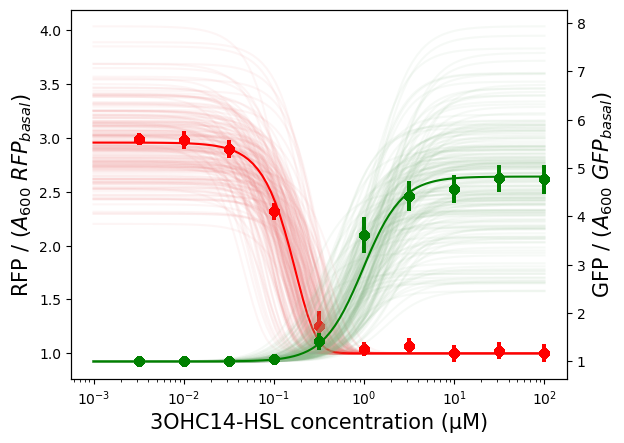

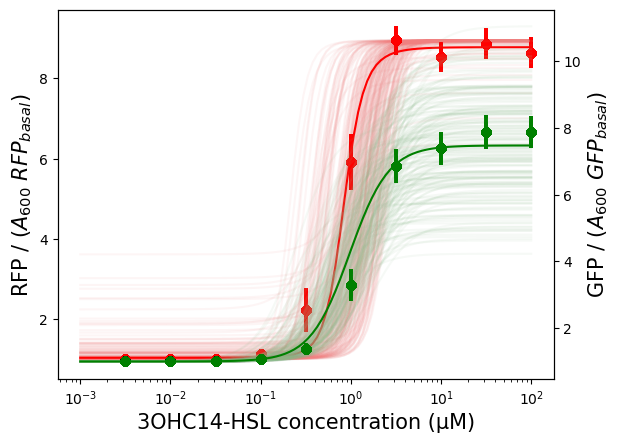

In [8]:

fig,ax = plt.subplots()
ax2=ax.twinx()
OC14_continuous = np.logspace(-3,2,100)

for p in parameters_list:
    fluorescenceFit = steadystate(OC14data_new, *p)
    fluorescenceFit_continuous = steadystate(OC14data_continuous, *p)
    fluorescenceSingleFit_continuous = steadystate(OC14data_continuous, *popt)
    gfpFit1 = fluorescenceFit[:5]; rfpFit1 = fluorescenceFit[5:10]; gfpFit3 = fluorescenceFit[10:16]; rfpFit3 = fluorescenceFit[16:22]
    gfpFit1_continuous = fluorescenceFit_continuous[:100]; rfpFit1_continuous = fluorescenceFit_continuous[100:200]; gfpFit3_continuous = fluorescenceFit_continuous[200:300]; rfpFit3_continuous = fluorescenceFit_continuous[300:400]
    gfpSingleFit1_continuous = fluorescenceSingleFit_continuous[:100]; rfpSingleFit1_continuous = fluorescenceSingleFit_continuous[100:200]; gfpSingleFit3_continuous = fluorescenceSingleFit_continuous[200:300]; rfpSingleFit3_continuous = fluorescenceSingleFit_continuous[300:400]
#     steadystate(OC14_continuous, *p)
    ax2.plot(OC14_continuous, gfpFit1_continuous, c='darkseagreen', alpha=0.08)
    ax.plot(OC14_continuous, rfpFit1_continuous, c='lightcoral', alpha=0.08)
    ax2.scatter(OC14_list1,gfpExp_list1 , label='data', c='green')
    ax2.errorbar(OC14_list1,gfpExp_list1,yerr=semGreen1,c='green',fmt='o')
    ax.scatter(OC14_list1,rfpExp_list1 , label='data', c='red')
    ax.errorbar(OC14_list1,rfpExp_list1,yerr=semRed1,c='red',fmt='o')
    plt.xscale('log')

# ax.legend(loc='center left') #upper right
ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$', fontsize=15)
ax.set_xscale('log')
# ax2.legend(loc='center right') #upper left
ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$',fontsize=15)
ax.set_xscale('log')
ax.set_xlabel(f'3OHC14-HSL concentration (µM)',fontsize=15)
ax.plot(OC14_continuous, rfpFit1_continuous_copy, c='red', alpha=1)
ax2.plot(OC14_continuous, gfpFit1_continuous_copy, c='green', alpha=1)
plt.show()

gfpFit1_continuous_copy
fig,ax = plt.subplots()
ax2=ax.twinx()
for p in parameters_list:
    fluorescenceFit = steadystate(OC14data_new, *p)
    fluorescenceFit_continuous = steadystate(OC14data_continuous, *p)
    gfpFit1 = fluorescenceFit[:5]; rfpFit1 = fluorescenceFit[5:10]; gfpFit3 = fluorescenceFit[10:16]; rfpFit3 = fluorescenceFit[16:22]
    gfpFit1_continuous = fluorescenceFit_continuous[:100]; rfpFit1_continuous = fluorescenceFit_continuous[100:200]; gfpFit3_continuous = fluorescenceFit_continuous[200:300]; rfpFit3_continuous = fluorescenceFit_continuous[300:400]
    
    ax2.plot(OC14_continuous, gfpFit3_continuous, c='darkseagreen', alpha=0.08)
    ax.plot(OC14_continuous, rfpFit3_continuous, c='lightcoral', alpha=0.08)
    ax2.scatter(OC14_list3,gfpExp_list3 , label='data', c='green')
    ax2.errorbar(OC14_list3,gfpExp_list3,yerr=semGreen3,c='green',fmt='o')
    ax.scatter(OC14_list3,rfpExp_list3 , label='data', c='red')
    ax.errorbar(OC14_list3,rfpExp_list3,yerr=semRed3,c='red',fmt='o')
    plt.xscale('log')


# ax.legend(loc='center left') #upper right
ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$', fontsize=15)
ax.set_xscale('log')
# ax2.legend(loc='center right') #upper left
ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$', fontsize=15)
ax.set_xscale('log')
ax.set_xlabel(f'3OHC14-HSL concentration (µM)', fontsize=15)

ax.plot(OC14_continuous, rfpFit3_continuous_copy, c='red', alpha=1)
ax2.plot(OC14_continuous, gfpFit3_continuous_copy, c='green', alpha=1)
plt.show()

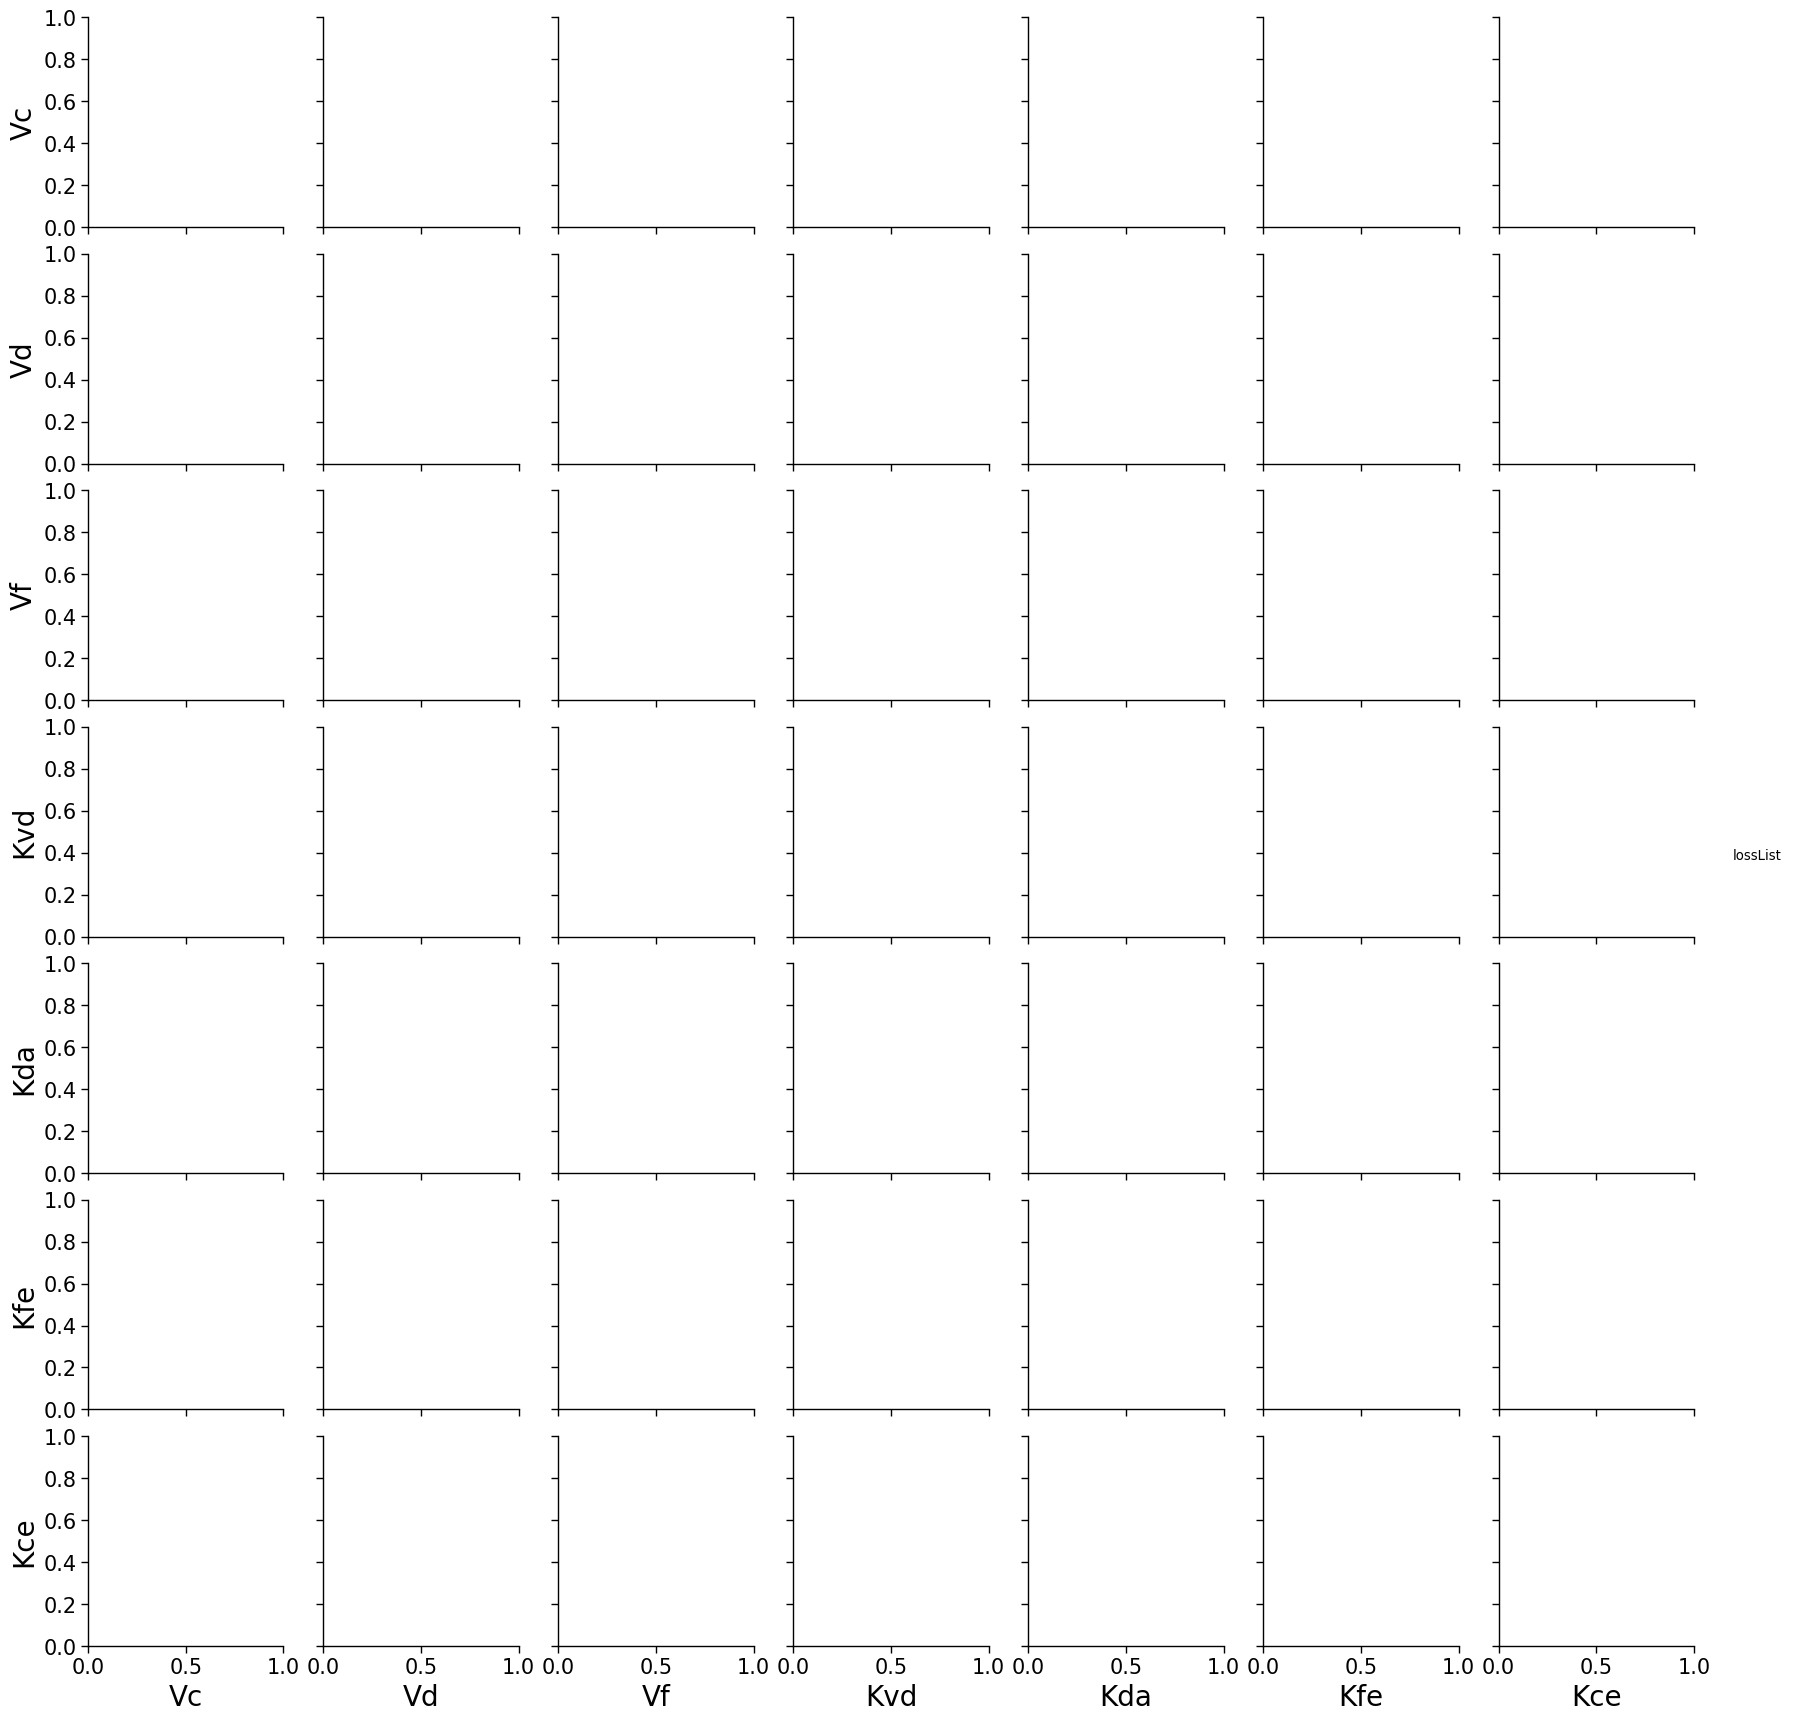

In [17]:
import pandas as pd
import seaborn as sns
sns.set_context("paper", rc={"axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15, "legend.fontsize":15, "axes.titlesize":20})

df = pd.DataFrame(parameters_list, columns=paramNames, corner=True)
df['lossList'] = np.log(lossList)

sns.pairplot(df, hue="lossList")
# sns.pairplot(df, hue="lossList", diag_kind='hist', diag_kws={'multiple': 'stack'},palette='rocket_r',corner=True)
# plt.show()

## Generate parameter set

In [10]:
pfitDict['Ve'] = np.amax([rfpExp_list3, rfpExp_list1]) - 1
pfitDict['nvd'] = nvd
pfitDict['nfe'] = nfe
pfitDict['nda'] = nda
pfitDict['nce'] = nce
pfitDict

{'Vc': 19.9552167334331,
 'Vd': 6.471382103657136,
 'Vf': 3.822697555075737,
 'Kvd': 0.7888206020550087,
 'Kda': 0.32780622726881464,
 'Kfe': 0.8941487200868288,
 'Kce': 3.58774099860374,
 'Ve': 7.9465648854961835,
 'nvd': 2,
 'nfe': 10,
 'nda': 2,
 'nce': 3}

In [11]:
#############
###paths#####
#############
import sys
import os




pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1]
sys.path.append(modellingpath + '/lib')
#############
from equations.parameterCreation_functions import *
#############
import numpy as np
import pandas as pd
import pickle as pkl
# %matplotlib inline
circuit_n=14
variant='fitted2'
#diffusion parameters


#maximum production parameters (V*)
minV = 10;maxV=1000;minb=0.1;maxb=1
Va = {'name':'Va','distribution':'loguniform', 'min':minV/maxb, 'max':maxV/minb}
Vb = {'name':'Vb','distribution':'loguniform', 'min':minV/maxb, 'max':maxV/minb}
# maxV=100;minV = 0.1
# Va = {'name':'Va','distribution':'loguniform', 'min':minV, 'max':maxV}
# Vb = {'name':'Vb','distribution':'loguniform', 'min':minV, 'max':maxV}

# Vc = {'name':'Vc','distribution':'gaussian', 'mean':pfitDict['Vc'], 'noisetosignal':0.3}
# Vd = {'name':'Vd','distribution':'gaussian', 'mean':pfitDict['Vd'], 'noisetosignal':0.3}
Ve = {'name':'Ve','distribution':'gaussian', 'mean':pfitDict['Ve'], 'noisetosignal':0.3}
# Vf = {'name':'Vf','distribution':'gaussian', 'mean':pfitDict['Vf'], 'noisetosignal':0.3}

# V_parameters = [Va,Vb, Vc, Vd, Ve, Vf]
V_parameters = [Va,Vb,Ve]



K1=0.0183; K2=0.0183
DUmin=0.1; DUmax=10; DVmin=0.1; DVmax=10
muU=0.0225; muV=0.0225
KdiffpromMin=0.1;KdiffpromMax=250
muLVA_estimate =1.143
muAAV_estimate =0.633
muASV_estimate=0.300 #this corresponds to mua

def Dr_(K1,K2,muU,muV,DU_,DV_):
    return (K2*DV_*muU)/(K1*DU_*muV)


def Kdiffstar(mudiff,Kdiffprom,kdiff):
    return mudiff*Kdiffprom/kdiff

def Kstar(mu,b,K):
    return mu/b*K

Dr = {'name':'Dr','distribution':'loguniform', 'min':Dr_(K1,K2,muU,muV,DUmax,DVmin), 'max':Dr_(K1,K2,muU,muV,DUmin,DVmax)}
D_parameters = [Dr]

# [] at half activation parameters (K)
minK=0.1;maxK=250

Keb = {'name':'Keb','distribution':'loguniform', 'min':Kstar(muLVA_estimate,maxb,minK), 'max':Kstar(muLVA_estimate,minb,maxK)}

Kee = {'name':'Kee','distribution':'fixed','value':0.001}

Kub = {'name':'Kub','distribution':'loguniform', 'min':Kdiffstar(muU,KdiffpromMin,K2), 'max':Kdiffstar(muU,KdiffpromMax,K2)}


# minK=0.1;maxK=10

# Keb = {'name':'Keb','distribution':'loguniform', 'min':minK, 'max':maxK}

# Kee = {'name':'Kee','distribution':'fixed','value':0.001}

# Kub = {'name':'Kub','distribution':'loguniform', 'min':minK, 'max':maxK}


# Kvd = {'name':'Kvd','distribution':'gaussian', 'mean':pfitDict['Kvd'], 'noisetosignal':0.3}
# Kda = {'name':'Kda','distribution':'gaussian', 'mean':pfitDict['Kda'], 'noisetosignal':0.3}
# Kce = {'name':'Kce','distribution':'gaussian', 'mean':pfitDict['Kce'], 'noisetosignal':0.3}
# Kfe = {'name':'Kfe','distribution':'gaussian', 'mean':pfitDict['Kfe'], 'noisetosignal':0.3}


# Kab = {'name':'Kab','distribution':'loguniform', 'min':muU_low*DU_low/k1, 'max':muU_high*DU_high/k1}
# Kbd = {'name':'Kbd','distribution':'loguniform', 'min':muV_low*DV_low/k2, 'max':muV_high*DV_high/k2}
# K_parameters = [ Kub, Keb, Kee, Kvd, Kda, Kce, Kfe]
K_parameters = [ Kub, Keb, Kee]



#protein degradation parameters (mu)
# mu = mux/mua
muASV = {'name':'muASV','distribution':'fixed', 'value':muASV_estimate/muASV_estimate}
muLVA = {'name':'muLVA','distribution': 'gaussian','mean':muLVA_estimate /muASV_estimate, 'noisetosignal':0.1}
mu_parameters = [muLVA,muASV]


#cooperativity parameters (n)
nvd = {'name':'nvd','distribution':'fixed', 'value':pfitDict['nvd']}
nfe = {'name':'nfe','distribution':'fixed', 'value': pfitDict['nfe']} #ideally hihger but we keep lower to ensure numerics work
nda = {'name':'nda','distribution':'fixed', 'value':pfitDict['nda']}
nce = {'name':'nce','distribution':'fixed', 'value':pfitDict['nce']}
nub = {'name':'nub','distribution':'fixed', 'value':1}
nee = {'name':'nee','distribution':'fixed', 'value':4}
neb = {'name':'neb','distribution':'fixed', 'value':4}
nfe = {'name':'nfe','distribution':'fixed', 'value':8}
n_parameters = [nub,nee,neb,nvd,nda,nce,nfe]

plotDistributions=False
if plotDistributions == True:
    D_parameters = [Dr, Dr]
    nsamples=10
    parameterTypeList = [ D_parameters  , V_parameters , K_parameters , mu_parameters , n_parameters]

    for parameterType in parameterTypeList:
        stackedDistributions = preLhs(parameterType)
        lhsDist = lhs(stackedDistributions,nsamples)
        lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterType])
        plotDist(parameterType,lhsDist_df)
createParams=True
if createParams == True:
    nsamples=1000
    # nsamples=int(sys.argv[1])
    # nsamples=14
    parameterDictList = D_parameters  + V_parameters + K_parameters + mu_parameters + n_parameters
    # parameterDictList = [DU, DV, bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF, Kbd, Kab, Kda, Kfe, Kee, Keb, Kce, KaTc, Kiptg, muLVA, muAAV, muASV, muUb, muVb, muaTc, muU, muV, nbd, nab, nda, nfe, nee, neb, nce, naTc, niptg, k1, k2, iptg]
    stackedDistributions = preLhs(parameterDictList)
    lhsDist = lhs(stackedDistributions,nsamples)
    lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterDictList])
    # plotDist(parameterDictList,lhsDist_df)
    # pkl.dump(lhsDist_df, open(modellingpath + '/3954/paper/input/fitted_parameterfiles/df_circuit%r_variant%s_%rparametersets.pkl'%(circuit_n,variant,nsamples), 'wb'))

    print(lhsDist_df)


100%|██████████| 16/16 [00:00<00:00, 558.23it/s]

            Dr          Va          Vb         Ve         Kub         Keb  \
0     0.033136   26.033833   49.471558   5.668986    0.217555    0.291891   
1    46.731119   79.591947  307.853355  11.801516    6.187796  638.061044   
2     0.928310   49.288417   69.899844   8.701519   25.165997   68.200920   
3     8.370748   27.815439  160.807777   8.054152   36.854345  295.309690   
4    11.102362   45.632377  198.253289   5.417570    0.237831   62.785513   
..         ...         ...         ...        ...         ...         ...   
995   0.204356   15.639749  145.581713  10.550991    0.170131    0.233925   
996   1.969072   88.846589   46.153282  13.356255  291.621535    0.340285   
997   0.425881  267.540429  856.298523   8.976043    1.723685   67.771568   
998   2.043808   63.096018   46.686430   6.014638   12.033484    5.576270   
999   0.813636   47.544043   15.868126   8.110598  272.039654   45.743462   

       Kee     muLVA  muASV  nub  nee  neb  nvd  nda  nce  nfe  
0    0.001

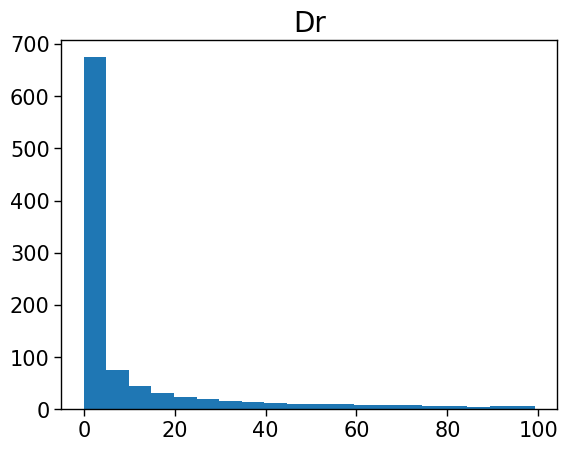

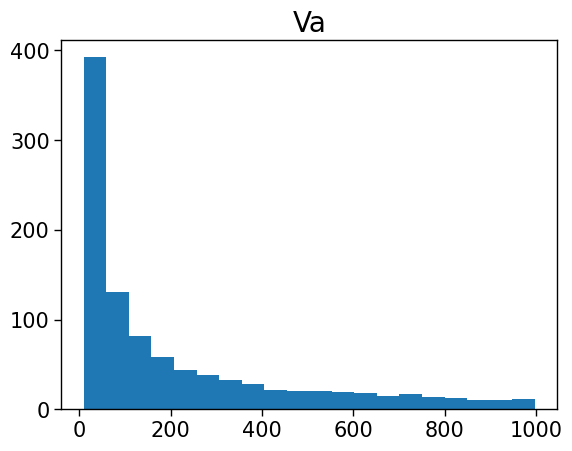

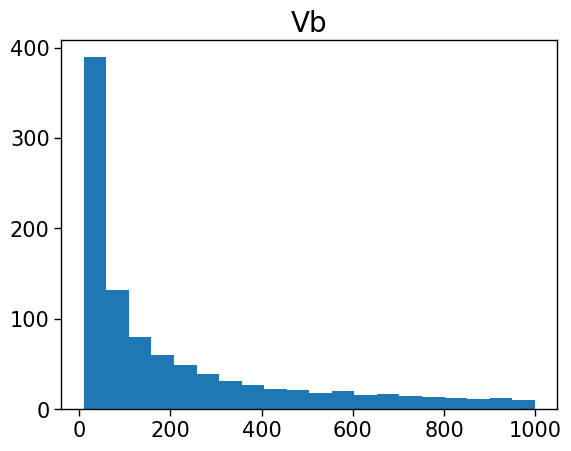

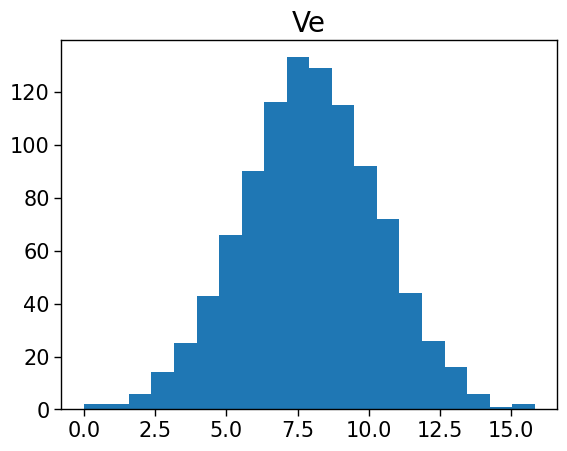

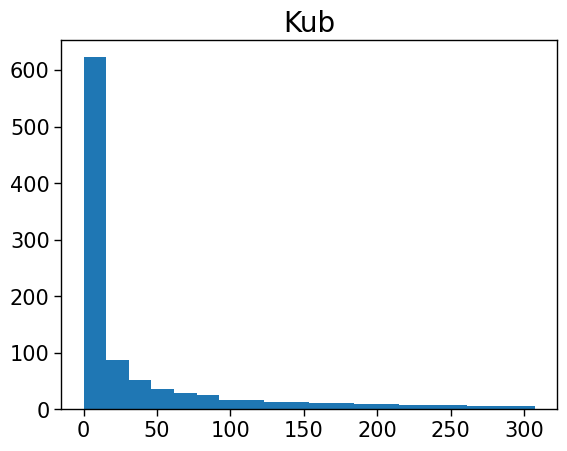

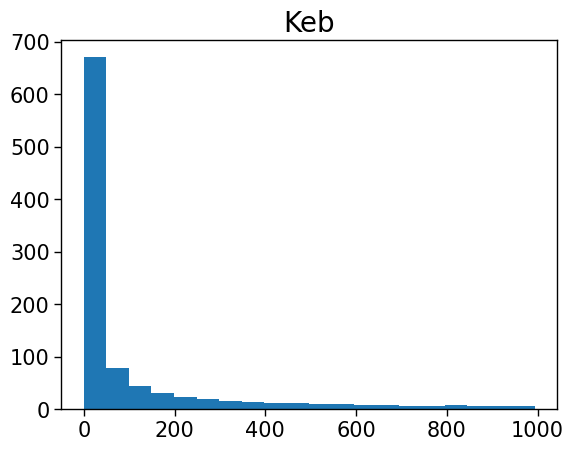

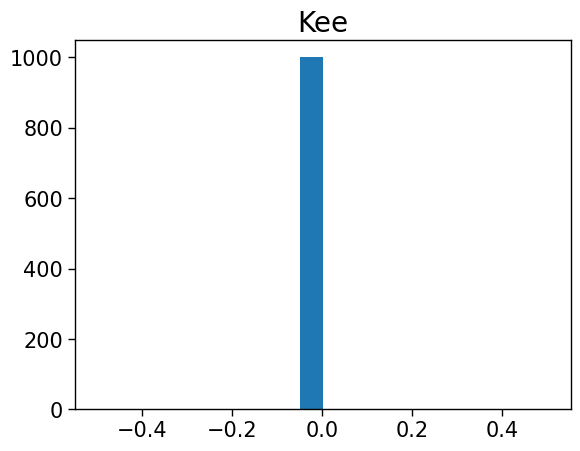

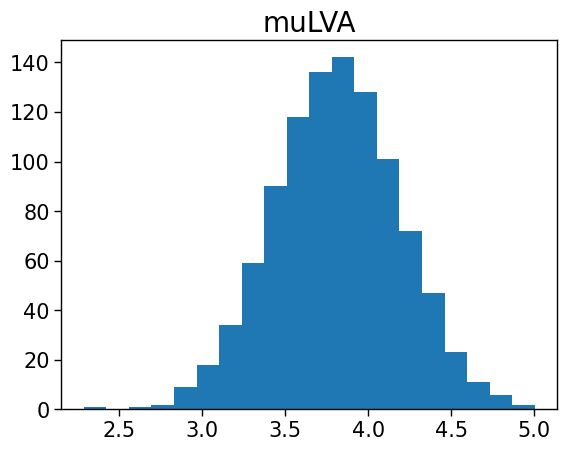

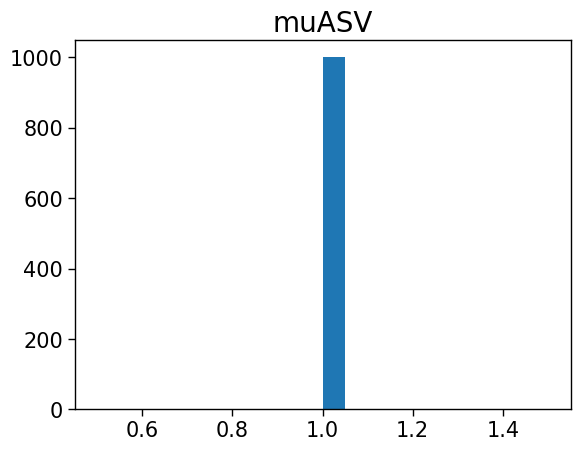

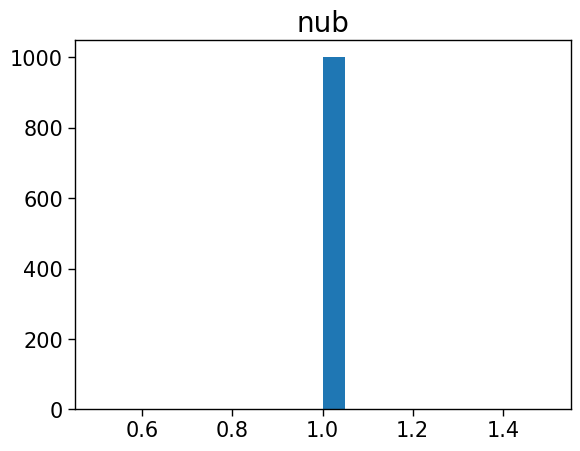

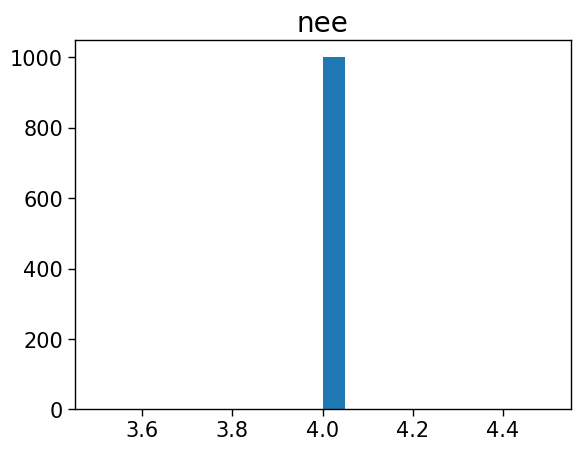

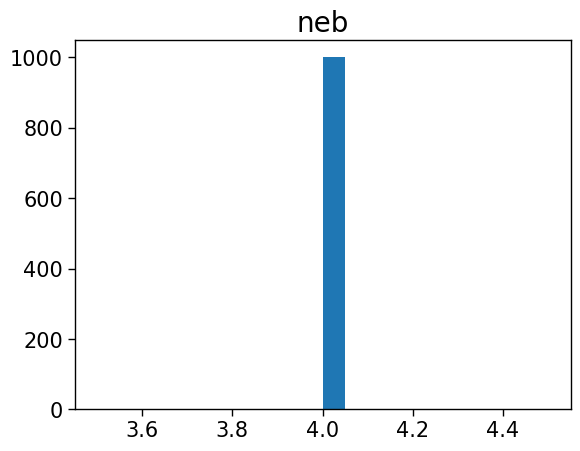

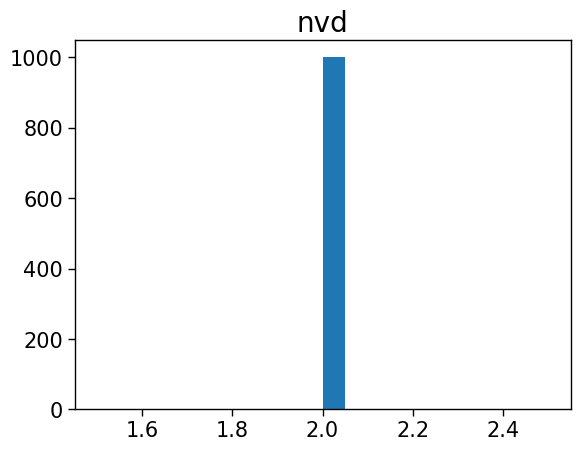

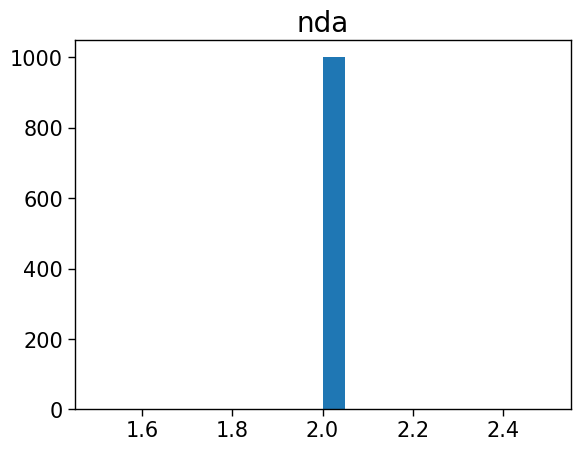

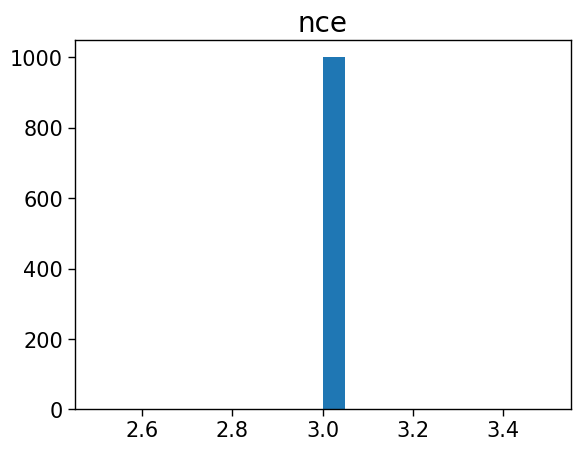

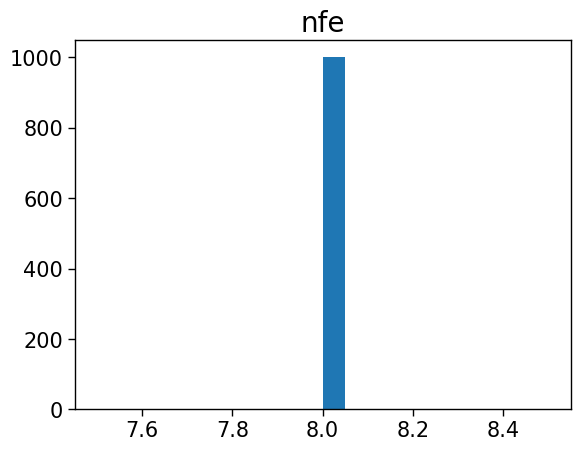

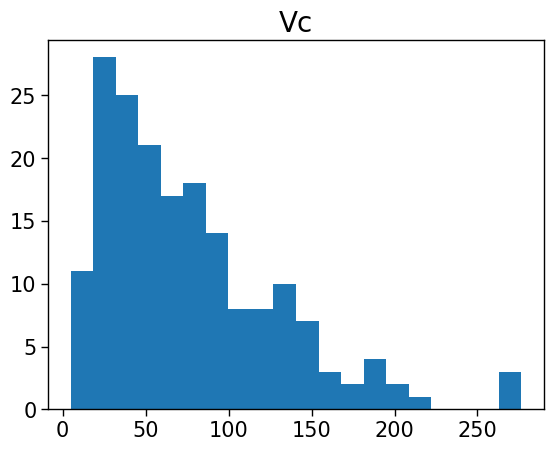

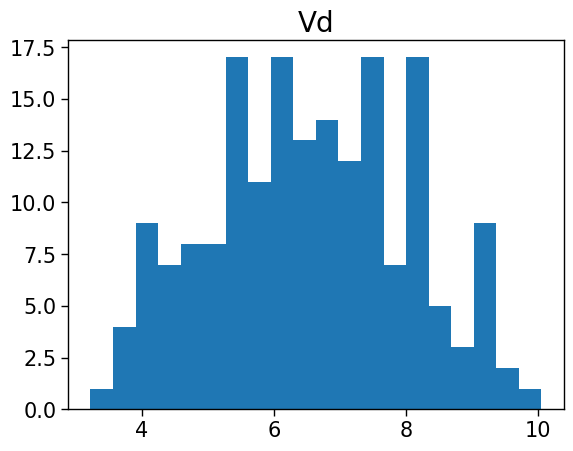

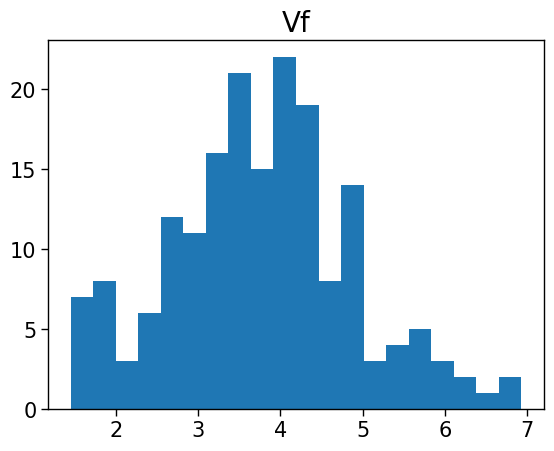

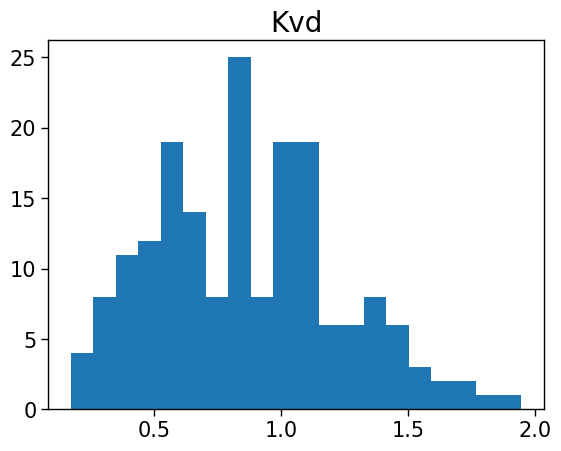

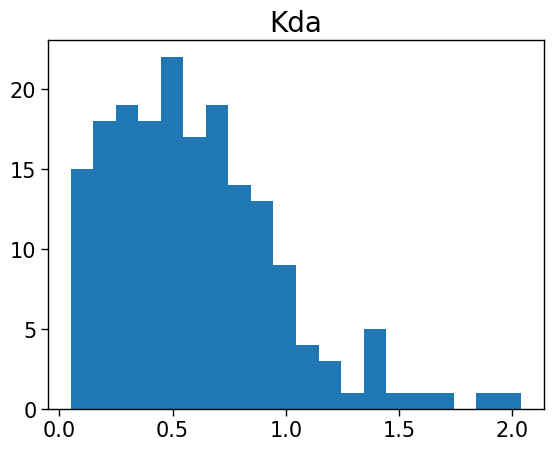

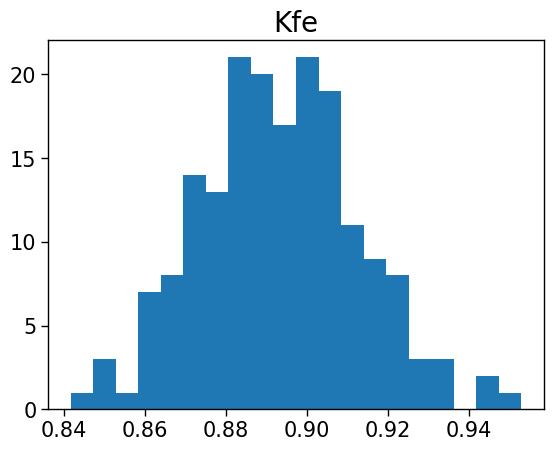

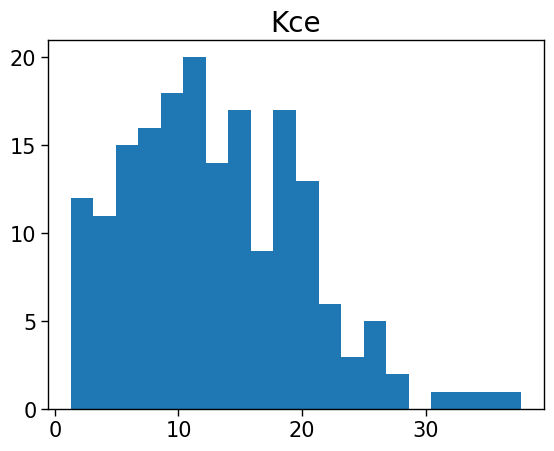

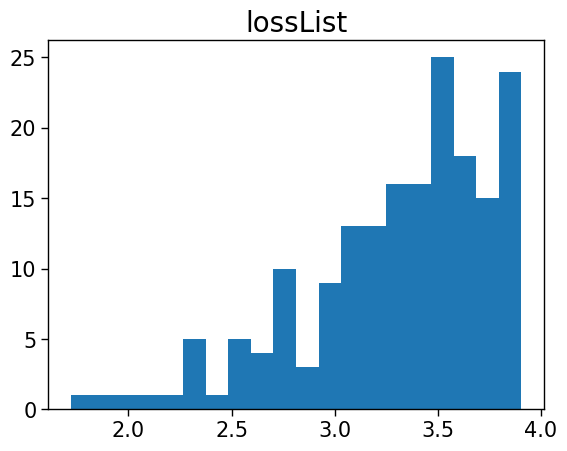

In [12]:
lhsDist_df
lhsDistFit_df=pd.concat([lhsDist_df, df], axis=1)

lhsDistFit_df

for column in lhsDistFit_df.columns:
    plt.hist(lhsDistFit_df[column],bins=20)
    plt.title(column)
    plt.show()
    

In [13]:
lhsDistFit_df = lhsDistFit_df.dropna()

In [14]:
lhsDistFit_df

,Dr,Va,Vb,Ve,Kub,Keb,Kee,muLVA,muASV,nub,...,nce,nfe,Vc,Vd,Vf,Kvd,Kda,Kfe,Kce,lossList
0,0.033136,26.033833,49.471558,5.668986,0.217555,0.291891,0.001,4.010167,1.0,1.0,...,3.0,8.0,42.138788,3.622287,4.461549,0.620091,0.555357,0.890882,9.691201,3.724018
1,46.731119,79.591947,307.853355,11.801516,6.187796,638.061044,0.001,3.042266,1.0,1.0,...,3.0,8.0,21.249504,6.419726,3.541048,0.485186,0.332797,0.891333,8.407885,2.805498
2,0.928310,49.288417,69.899844,8.701519,25.165997,68.200920,0.001,4.272536,1.0,1.0,...,3.0,8.0,143.236072,8.509480,3.885156,1.021242,1.042691,0.911916,26.257439,3.662156
3,8.370748,27.815439,160.807777,8.054152,36.854345,295.309690,0.001,4.315507,1.0,1.0,...,3.0,8.0,97.664133,7.647352,2.815889,0.386606,0.385722,0.904923,17.183379,3.399914
4,11.102362,45.632377,198.253289,5.417570,0.237831,62.785513,0.001,4.249729,1.0,1.0,...,3.0,8.0,149.324731,4.849539,4.086340,0.959995,0.336754,0.891958,17.439307,2.808507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,1.125348,24.995200,851.654245,6.403894,5.325856,969.506820,0.001,3.485164,1.0,1.0,...,3.0,8.0,15.328924,9.077229,4.630599,0.844259,0.935387,0.890539,10.119381,3.678972
178,0.010430,207.558453,11.637616,9.492275,0.128030,276.453609,0.001,3.748416,1.0,1.0,...,3.0,8.0,89.089711,4.583034,4.053827,0.826196,0.114672,0.871035,8.724566,3.344574
179,0.669906,676.543514,50.579976,10.033853,0.165573,5.692431,0.001,4.198110,1.0,1.0,...,3.0,8.0,108.001919,7.211861,4.764762,0.819771,0.433175,0.866122,16.372258,2.469843
180,6.435422,13.538436,476.777811,6.172999,4.420467,0.407562,0.001,4.148315,1.0,1.0,...,3.0,8.0,185.760379,6.492170,3.978929,0.582310,0.114968,0.903208,17.558567,2.783018


In [15]:

Km_list = ['Kda', 'Kub', 'Keb', 'Kvd', 'Kfe',  'Kce' ]
KtoV = {'Kda': 'Vd', 'Kub': 'Va', 'Keb': 'Ve', 'Kvd': 'Vb', 'Kfe': 'Vf','Kce': 'Vc' }

def checkBalance(par_dict):
    balanceDict = {}
    for Km in Km_list:
        # print(Km)
        Vx =par_dict[KtoV[Km]]
        Kxy = par_dict[Km]
        if Kxy >= 1 and Kxy <= Vx:
            balanceDict[Km] = 'Balanced'

        elif Kxy > 0.1 and Kxy < Vx*10:
            balanceDict[Km] ='Semi balanced'
        elif Kxy <= 0.1 or Kxy >= Vx*10:
            balanceDict[Km] ='Not balanced'
        else:
            print('ERROR!!!!!!!!!')

    if 'Not balanced' in balanceDict.values():
        return 'Not balanced'
    elif 'Semi balanced'  in balanceDict.values():
        print('semibalanced')
        return 'Semi balanced'
    elif all(x == 'Balanced' for x in balanceDict.values()):
        print('Balanced')
        return 'Balanced'
    

createBalancedParams=True
if createBalancedParams == True:
    nsamples=10
    # parameterDictList = D_parameters  + V_parameters + K_parameters + mu_parameters + n_parameters
    # stackedDistributions = preLhs(parameterDictList)
    balancedDf = pd.DataFrame()
    semiBalancedDf = pd.DataFrame()
    notBalancedDf = pd.DataFrame()
# while len(balancedDf)<nsamples:
    # lhsDist = lhs(stackedDistributions,nsamples, seed = seed, tqdm_disable = True)
    # lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterDictList])
    #check balance

    balanceList = []    
    for parID in lhsDistFit_df.index:
        par_dict = lhsDistFit_df.loc[parID].to_dict()
        balanceList.append(checkBalance(par_dict))
    lhsDistFit_df['balance'] = balanceList
    
    #separate 3df
    balancedDfPre = lhsDistFit_df[lhsDistFit_df['balance']=='Balanced']
    semiBalancedDfPre = lhsDistFit_df[lhsDistFit_df['balance']=='Semi balanced']
    notBalancedDfPre = lhsDistFit_df[lhsDistFit_df['balance']=='Not balanced']
    
    #concat to df
    if len(balancedDf)<nsamples:
        balancedDf = pd.concat([balancedDf, balancedDfPre], ignore_index=True)
    if len(semiBalancedDf)<nsamples:
        semiBalancedDf = pd.concat([semiBalancedDf, semiBalancedDfPre], ignore_index=True)
    if len(notBalancedDf)<nsamples:
        notBalancedDf = pd.concat([notBalancedDf, notBalancedDfPre], ignore_index=True)

    lhsDistFit_df_balancesemibalance = lhsDistFit_df[lhsDistFit_df['balance']!='Not balanced']
        # pkl.dump(balancedDf[:nsamples], open(modellingpath + '/3954/paper/input/balanced_parameterfiles/df_circuit%r_variant%s_%rparametersets_balanced.pkl'%(circuit_n,variant,nsamples), 'wb'))
        # pkl.dump(semiBalancedDf[:nsamples], open(modellingpath + '/3954/paper/input/balanced_parameterfiles/df_circuit%r_variant%s_%rparametersets_semiBalanced.pkl'%(circuit_n,variant,nsamples), 'wb'))
        # pkl.dump(notBalancedDf[:nsamples], open(modellingpath + '/3954/paper/input/balanced_parameterfiles/df_circuit%r_variant%s_%rparametersets_notBalanced.pkl'%(circuit_n,variant,nsamples), 'wb'))
        # pkl.dump(lhsDist_df, open(modellingpath + '/3954/paper/input/lhs_parameterfiles/df_circuit%r_variant%s_%rparametersets.pkl'%(circuit_n,variant,nsamples), 'wb'))


len(balancedDf), len(semiBalancedDf), len(notBalancedDf), len(lhsDistFit_df_balancesemibalance)

semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced

(0, 122, 60, 122)